In [16]:
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [2]:
labels={1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane", 6: "bus", 7: "train", 8: "truck", 9: "boat",
 10:"traffic light", 11: "fire hydrant", 13: "stop sign", 14: "parking meter", 15: "bench", 16: "bird",17: "cat",
 18: "dog", 19: "horse", 20: "sheep", 21: "cow", 22: "elephant", 23: "bear", 24: "zebra",25: "giraffe",27: "backpack",
 28: "umbrella",31: "handbag",32: "tie",33: "suitcase",34: "frisbee",35: "skis",36: "snowboard",37: "sports ball",
 38: "kite",39: "baseball bat",40: "baseball glove", 41: "skateboard", 42: "surfboard", 43: "tennis racket", 
 44: "bottle", 46: "wine glass", 47: "cup", 48: "fork", 49: "knife", 50: "spoon", 51: "bowl", 52: "banana",
 53: "apple", 54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot", 58: "hot dog", 59: "pizza", 60: "donut",
 61: "cake", 62: "chair", 63: "couch", 64: "potted plant", 65: "bed", 67: "dining table", 70: "toilet", 72: "tv",
 73: "laptop", 74: "mouse", 75: "remote", 76: "keyboard", 77: "cell phone", 78: "microwave", 79: "oven", 80: "toaster",
 81: "sink", 82: "refrigerator", 84: "book", 85: "clock", 86: "vase", 87: "scissors",88: "teddy bear",89:"hair drier",
 90: "toothbrush"}

In [3]:
def load_graph(graph_file, use_xla=False):
    jit_level = 0
    config = tf.ConfigProto()
    if use_xla:
        jit_level = tf.OptimizerOptions.ON_1
        config.graph_options.optimizer_options.global_jit_level = jit_level

    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        ops = sess.graph.get_operations()
        n_ops = len(ops)
        return sess, ops

In [4]:
path1 = './rfcn_resnet101_coco_2017_11_08/frozen_inference_graph.pb'
path2 = './ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb'
sess, base_ops = load_graph(path1)

# Testing graph

In [13]:
# print(base_ops)
# for operation in base_ops:
#     print(operation.name)
graph=sess.graph
with tf.Session() as session:
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = graph.get_tensor_by_name('detection_boxes:0') 
    detection_classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')
    detection_scores = graph.get_tensor_by_name('detection_scores:0')

    image_path = "./1.jpg"
    image = Image.open(image_path)
#     image = image.crop((0,100,image.size[0],image.size[1]/2+100))

    image_np = np.array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],
      feed_dict={image_tensor: image_np_expanded})


(300, 4)
365.962100029 120.664191246 454.511475563 162.20600605


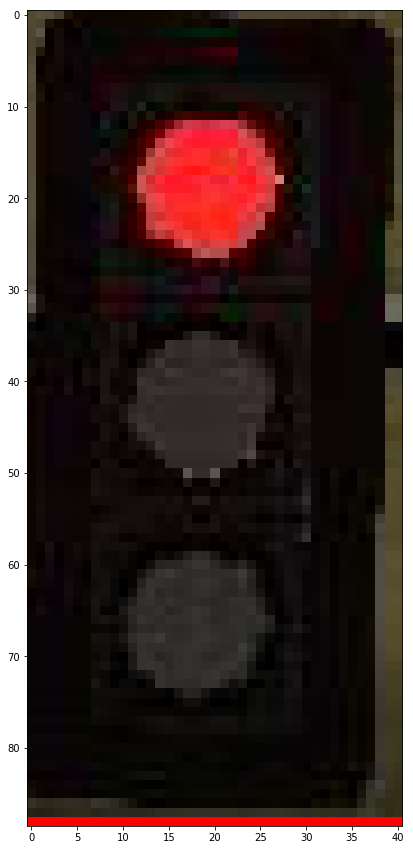

376.096522808 465.552091599 462.128806114 506.974220276


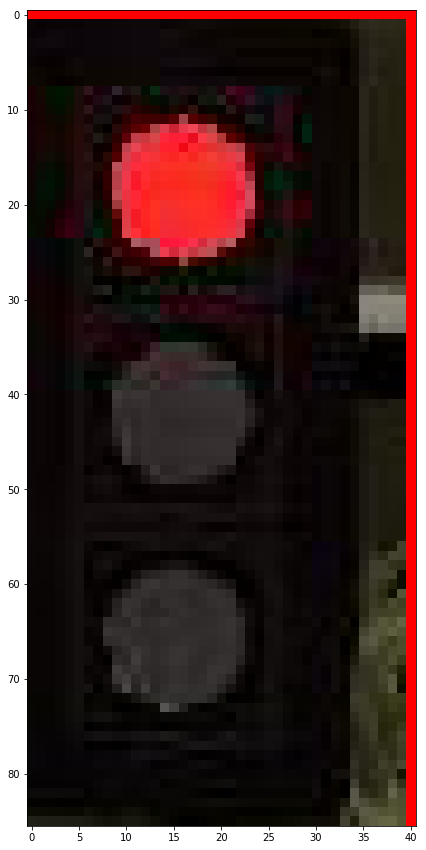

371.259605885 291.407346725 456.349718571 332.535648346


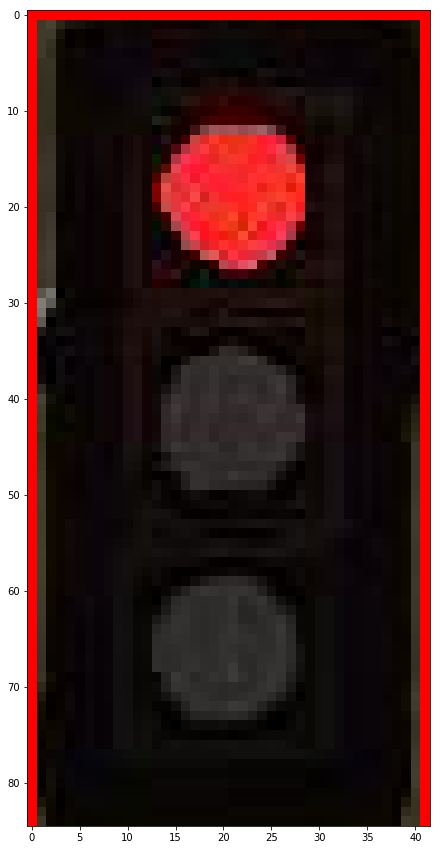

313.803184032 620.886135101 406.080651283 669.486141205


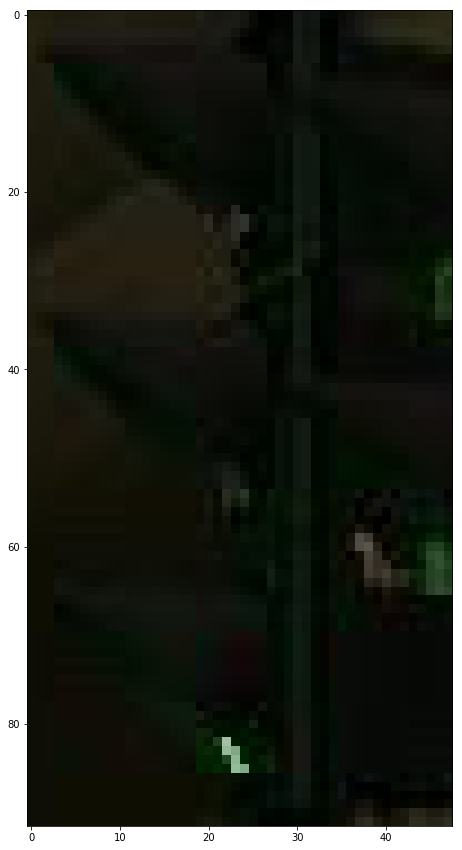

247.579336166 707.407045364 358.175003529 752.846956253


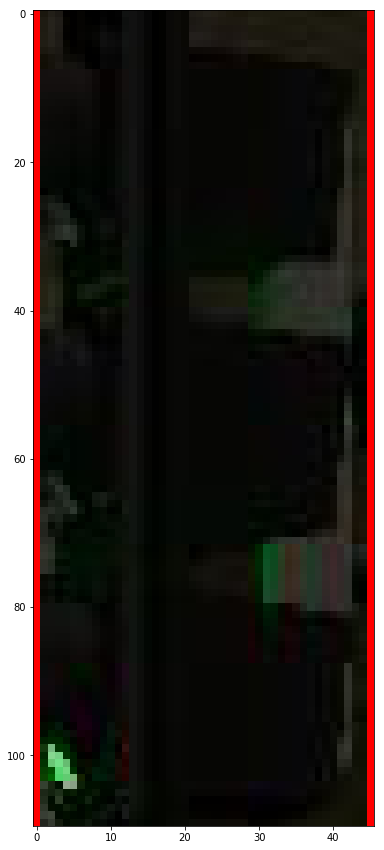

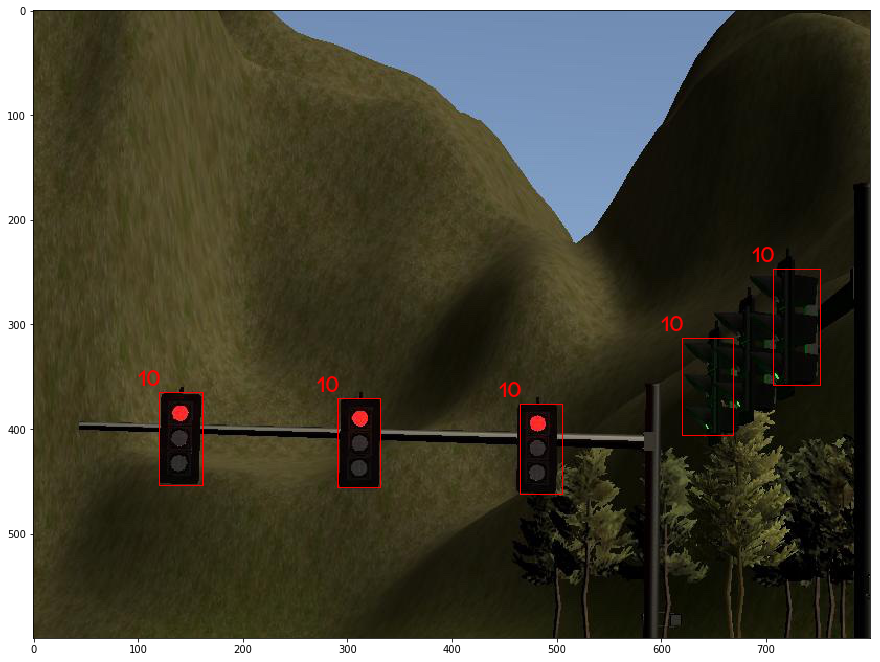

In [24]:
boxes = np.squeeze(boxes)
scores = np.squeeze(scores)
classes = np.squeeze(classes).astype(np.int32)
image = Image.open(image_path)
# image = image.crop((0,100,image.size[0],image.size[1]/2+100))

draw = ImageDraw.Draw(image)
im_height, im_width = image.size

min_score_thresh = .50
print(boxes.shape)
for i in range(boxes.shape[0]):
    if scores is None or scores[i] > min_score_thresh:
#         (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
#                                   ymin * im_height, ymax * im_height)
        font = ImageFont.truetype("sg-alternative.high-alt.otf", 20)
        # draw.text((x, y),"Sample Text",(r,g,b))
        
        (left, right, top, bottom) = (boxes[i][0] * im_width, boxes[i][2] * im_width, boxes[i][1] * im_height, boxes[i][3] * im_height)
        draw.rectangle(((top,left ), (bottom,right )), fill=None, outline=(255, 0, 0))
        draw.text((top-20,left-20),str(classes[i]),(255,0,0), font=font)
        print(left, top, right, bottom)
        im_crop = image.crop((top, left,bottom,right ))
        plt.figure(figsize=(15,15))
        plt.imshow(im_crop)
        plt.show()
#         im_crop.save('{}.png'.format(uuid.uuid4().hex))
        b_w = right-left
        b_h = top-bottom
        area = int(abs(b_w*b_h))
#         draw.text((top-20,left+20),str(area),(255,0,0), font=font)
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.show()

# Retraining graph

In [13]:
graph=sess.graph
with tf.Session() as session:
    print(graph)
    print(base_ops)

[<tf.Operation 'image_tensor' type=Placeholder>, <tf.Operation 'ToFloat' type=Cast>, <tf.Operation 'Preprocessor/map/Shape' type=Shape>, <tf.Operation 'Preprocessor/map/TensorArrayUnstack/Shape' type=Shape>, <tf.Operation 'SecondStageBoxPredictor/class_predictions/weights/read/_556__cf__562' type=Const>, <tf.Operation 'SecondStageBoxPredictor/class_predictions/biases/read/_555__cf__561' type=Const>, <tf.Operation 'SecondStageBoxPredictor/reduce_depth/weights/read/_501__cf__507' type=Const>, <tf.Operation 'SecondStageBoxPredictor/reduce_depth/biases/read/_500__cf__506' type=Const>, <tf.Operation 'SecondStageBoxPredictor/refined_locations/biases/read/_499__cf__505' type=Const>, <tf.Operation 'Slice/begin/_495__cf__501' type=Const>, <tf.Operation 'FirstStageBoxPredictor/ClassPredictor/weights/read/_494__cf__500' type=Const>, <tf.Operation 'FirstStageBoxPredictor/ClassPredictor/biases/read/_493__cf__499' type=Const>, <tf.Operation 'GridAnchorGenerator/Meshgrid_3/Reshape/_489__cf__495' type